# FAISS (Facebook AI Similarity Search) - Create a search index
## Use the feature extraction model to get image embeddings

In [1]:
from resnet_classifier import TransferLearning
import torch

feature_extraction_model = TransferLearning()
feature_extraction_model.load_state_dict(torch.load('resnet_model_weights.pth'))

first_linear_layer = list(feature_extraction_model.layers.fc.children())[0]
feature_extraction_model.layers.fc = first_linear_layer
feature_extraction_model.layers.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [3]:
from torchvision.transforms import ToTensor
from PIL import Image
from dataset import import_tabular_data

merged_df = import_tabular_data()

image_idx = 1
num_images = len(merged_df)
image_id = merged_df.image_id[image_idx]
# true_label = merged_df.category_0[image_idx]

def generate_feature_embedding(model, image_id, return_type='list'):
    img = Image.open(f'./cleaned_images_64/{image_id}.jpg')
    model.eval()
    transform = ToTensor()
    img_tensor = transform(img)
    img_tensor_reshape = torch.unsqueeze(img_tensor, dim=0)
    
    embedding_tensor = model(img_tensor_reshape)
    
    if return_type == 'list':
        # Returns a list of size 1000
        embedding = embedding_tensor.detach().squeeze().tolist()
    
    elif return_type == 'numpy':
        # Returns a numpy array of size 1000
        embedding = embedding_tensor.detach().squeeze().numpy() 

    
    return embedding

embedding = generate_feature_embedding(model = feature_extraction_model, image_id = image_id, return_type='numpy')
type(embedding), len(embedding)

(numpy.ndarray, 1000)

In [31]:
from tqdm import tqdm
image_embeddings = dict()
for image_idx in tqdm(range(num_images)):
    image_id = merged_df.image_id[image_idx]
    image_embeddings[image_id] = generate_feature_embedding(model=feature_extraction_model, image_id=image_id)

100%|██████████| 12604/12604 [13:55<00:00, 15.09it/s] 


In [32]:
import json
import os

if not os.path.exists('./image_embeddings.json'):
    with open('image_embeddings.json', 'w') as fp:
        json.dump(image_embeddings, fp)

In [5]:
from tqdm import tqdm
import numpy as np

numpy_embeddings = np.empty((num_images, 1000))
for image_idx in tqdm(range(num_images)):
    image_id = merged_df.image_id[image_idx]
    numpy_embeddings[image_idx,:] = generate_feature_embedding(model=feature_extraction_model, image_id=image_id, return_type='numpy')

100%|██████████| 12604/12604 [12:38<00:00, 16.62it/s] 


In [10]:
import os

if not os.path.exists('./image_embeddings.npy'):
    np.save('image_embeddings.npy', numpy_embeddings)

## Load the image embeddings and build FAISS

In [3]:
import json
with open('image_embeddings.json') as f:
    load_embeddings = json.load(f)

In [12]:
image_embeddings = np.load('./image_embeddings.npy')

In [13]:
image_embeddings.shape[1]

1000

In [40]:
import faiss

index = faiss.IndexFlatL2(1000)

In [41]:
index.is_trained

True

In [42]:
index.add(image_embeddings)

In [43]:
index.ntotal

12604

In [44]:
%%time
k = 4
xq = image_embeddings[0,:]
xq = xq[np.newaxis, :]
D, I = index.search(xq, k)
print(I)

[[   0 9938 1858 9649]]
CPU times: user 7.18 ms, sys: 0 ns, total: 7.18 ms
Wall time: 6.85 ms


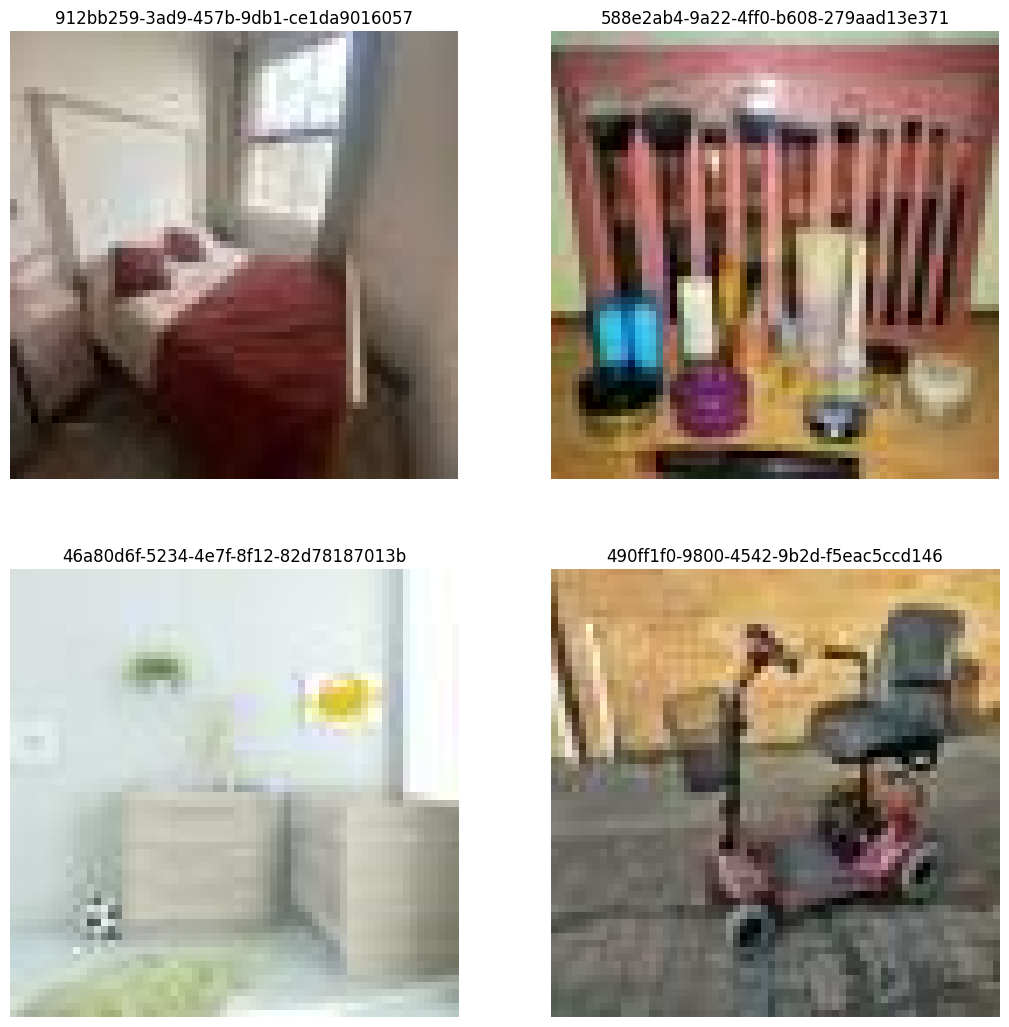

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

merged_df.image_id.loc[I[0]]

fig, ax = plt.subplots(2,2, figsize = (12.8, 12.8))

for idx in range(4):
    image_id = merged_df.image_id.loc[I[0][idx]]
    img = mpimg.imread(f'./cleaned_images_64/{image_id}.jpg')
    if idx < 2:
        ax_i = idx%2
        ax[0, ax_i].imshow(img)
        ax[0, ax_i].axis('off')
        ax[0, ax_i].set_title(f'{image_id}')
    else:
        ax_i = idx%2
        ax[1, ax_i].imshow(img)
        ax[1, ax_i].axis('off')
        ax[1, ax_i].set_title(f'{image_id}');

In [46]:
D[0]

array([  0.      ,  97.62644 ,  98.64966 , 100.398445], dtype=float32)

In [66]:
# Can also partition the idx
nlist = 100  # how many cells
quantizer = faiss.IndexFlatL2(1000)
index = faiss.IndexIVFFlat(quantizer, 1000, nlist)

In [67]:
index.is_trained

False

In [68]:
index.train(image_embeddings)
index.is_trained

True

In [69]:
index.add(image_embeddings)
index.ntotal

12604

In [71]:
%%time
D, I = index.search(xq, k)  # search
print(I)

[[   0 9938 1858 9649]]
CPU times: user 0 ns, sys: 2.27 ms, total: 2.27 ms
Wall time: 1.63 ms


In [72]:
nlist=70 # If nlist is too low, the search won't be optimal
quantizer = faiss.IndexFlatL2(1000)
index = faiss.IndexIVFFlat(quantizer, 1000, nlist)
index.train(image_embeddings)
index.add(image_embeddings)
D, I = index.search(xq, k)  # search
print(I)

[[    0 11728  6353  3277]]
